In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [83]:
from numpy.random import seed
seed(1)

In [84]:
dataset=pd.read_csv("Data/testset.csv")
dataset

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.00,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.00,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.20,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99565,20161231-12:00,Partly Cloudy,15.0,0,0,NaN,77.0,NaN,1015.0,0,0,18.0,0,0,0.50,110.0,ESE,NaN,NaN,7.4
99566,20161231-13:00,Partly Cloudy,16.0,0,0,NaN,100.0,NaN,1014.0,0,0,16.0,0,0,0.80,90.0,East,NaN,NaN,3.7
99567,20161231-15:00,NaN,13.0,0,0,NaN,NaN,NaN,1016.0,0,0,NaN,0,0,0.05,10.0,North,NaN,NaN,59.3
99568,20161231-18:00,Patches of Fog,12.0,1,0,NaN,100.0,NaN,1016.0,0,0,12.0,0,0,0.50,NaN,NaN,NaN,NaN,0.0


In [85]:
dataset.columns=dataset.columns.str.replace("_","")
dataset.columns=dataset.columns.str.replace(" ","")
dataset.columns

Index(['datetimeutc', 'conds', 'dewptm', 'fog', 'hail', 'heatindexm', 'hum',
       'precipm', 'pressurem', 'rain', 'snow', 'tempm', 'thunder', 'tornado',
       'vism', 'wdird', 'wdire', 'wgustm', 'windchillm', 'wspdm'],
      dtype='object')

In [86]:
print(dataset["conds"].value_counts())

Haze                             47003
Smoke                            20551
Mist                              9104
Clear                             3129
Widespread Dust                   2830
Fog                               2656
Scattered Clouds                  2197
Partly Cloudy                     2070
Shallow Fog                       1860
Mostly Cloudy                     1520
Light Rain                        1297
Partial Fog                       1004
Patches of Fog                     850
Thunderstorms and Rain             471
Heavy Fog                          418
Light Drizzle                      410
Rain                               394
Unknown                            382
Blowing Sand                       358
Overcast                           313
Thunderstorm                       190
Light Thunderstorms and Rain       170
Drizzle                            111
Light Thunderstorm                  63
Light Fog                           56
Heavy Rain               

In [87]:
dataset["conds"]=dataset["conds"].replace(["Widespread Dust","Blowing Sand","Sandstorm", "Volcanic Ash","Light Sandstorm"],"Dust")
dataset["conds"]=dataset["conds"].replace(["Fog", "Shallow Fog", "Partial Fog","Light Fog", "Mist", "Heavy Fog", "Light Haze","Patches of Fog"],"Fog")
dataset["conds"]=dataset["conds"].replace(["Scattered Clouds", "Partly Cloudy",  "Mostly Cloudy" ,"Overcast","Funnel Cloud"], "Cloudy")
dataset["conds"]=dataset["conds"].replace(["Light Rain", "Light Drizzle","Rain", "Drizzle", "Light Rain Showers","Drizzle" ,"Rain Showers"], "Rain")
dataset["conds"]=dataset["conds"].replace(["Thunderstorms with Hail", "Squalls","Light Hail Showers" ,"Light Freezing Rain","Heavy Thunderstorms with Hail", "Unknown"], "Others")
dataset["conds"]=dataset["conds"].replace(["Thunderstorms and Rain", "Light Thunderstorms and Rain","Light Thunderstorm" ,"Heavy Thunderstorms and Rain","Heavy Rain"], "Thunderstorm")

In [88]:
print(dataset["conds"].value_counts())

Haze            47003
Smoke           20551
Fog             15952
Cloudy           6102
Dust             3200
Clear            3129
Rain             2219
Thunderstorm      942
Others            402
Name: conds, dtype: int64


In [89]:
le=LabelEncoder()
col="conds"
dataset[col]=dataset.apply(lambda x: le.fit_transform(dataset[col].astype(str)),axis=0,result_type='expand')
dataset["conds"]

0        7
1        7
2        7
3        7
4        7
        ..
99565    1
99566    1
99567    9
99568    3
99569    3
Name: conds, Length: 99570, dtype: int64

In [90]:
dataset['pressurem'].replace('-9999.0',np.nan)
dataset.replace(0,np.nan)
dataset.isnull().sum()

datetimeutc        0
conds              0
dewptm           620
fog                0
hail               0
heatindexm     70457
hum              756
precipm        99570
pressurem        232
rain               0
snow               0
tempm            672
thunder            0
tornado            0
vism            4428
wdird          14492
wdire          14492
wgustm         98507
windchillm     98997
wspdm           2358
dtype: int64

In [91]:
dataset

,datetimeutc,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,snow,tempm,thunder,tornado,vism,wdird,wdire,wgustm,windchillm,wspdm
0,19961101-11:00,7,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.00,280.0,West,NaN,NaN,7.4
1,19961101-12:00,7,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,7,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,7,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.00,0.0,North,NaN,NaN,NaN
4,19961101-16:00,7,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.20,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99565,20161231-12:00,1,15.0,0,0,NaN,77.0,NaN,1015.0,0,0,18.0,0,0,0.50,110.0,ESE,NaN,NaN,7.4
99566,20161231-13:00,1,16.0,0,0,NaN,100.0,NaN,1014.0,0,0,16.0,0,0,0.80,90.0,East,NaN,NaN,3.7
99567,20161231-15:00,9,13.0,0,0,NaN,NaN,NaN,1016.0,0,0,NaN,0,0,0.05,10.0,North,NaN,NaN,59.3
99568,20161231-18:00,3,12.0,1,0,NaN,100.0,NaN,1016.0,0,0,12.0,0,0,0.50,NaN,NaN,NaN,NaN,0.0


In [92]:
hum_median=dataset["hum"].median()
dataset["hum"].fillna(hum_median,inplace=True)
pressurem_median=dataset["pressurem"].median()
dataset["pressurem"].fillna(pressurem_median,inplace=True)
wspdm_median=dataset["wspdm"].median()
dataset["wspdm"].fillna(wspdm_median,inplace=True)
tempm_median=dataset["tempm"].median()
dataset["tempm"].fillna(tempm_median,inplace=True)

In [93]:
dataset.isnull().sum()

datetimeutc        0
conds              0
dewptm           620
fog                0
hail               0
heatindexm     70457
hum                0
precipm        99570
pressurem          0
rain               0
snow               0
tempm              0
thunder            0
tornado            0
vism            4428
wdird          14492
wdire          14492
wgustm         98507
windchillm     98997
wspdm              0
dtype: int64

In [94]:
dataset_regression=dataset[['datetimeutc','hum','tempm','pressurem','wspdm']]

In [95]:
dataset_regression["datetimeutc"]=pd.to_datetime(dataset_regression["datetimeutc"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
dataset_regression.set_index("datetimeutc",inplace=True)

In [97]:
dataset_regression

,hum,tempm,pressurem,wspdm
datetimeutc,,,,
1996-11-01 11:00:00,27.0,30.0,1010.0,7.4
1996-11-01 12:00:00,32.0,28.0,-9999.0,7.4
1996-11-01 13:00:00,44.0,24.0,-9999.0,7.4
1996-11-01 14:00:00,41.0,24.0,1010.0,7.4
1996-11-01 16:00:00,47.0,23.0,1011.0,0.0
...,...,...,...,...
2016-12-31 12:00:00,77.0,18.0,1015.0,7.4
2016-12-31 13:00:00,100.0,16.0,1014.0,3.7
2016-12-31 15:00:00,58.0,27.0,1016.0,59.3


In [99]:
dataset_regression=dataset_regression.resample("D").mean()
dataset_regression

,hum,tempm,pressurem,wspdm
datetimeutc,,,,
1996-11-01,52.916667,22.333333,-2659.666667,6.166667
1996-11-02,48.625000,22.916667,1009.833333,7.950000
1996-11-03,55.958333,21.791667,1010.500000,5.020833
1996-11-04,48.055556,22.722222,1011.333333,2.266667
1996-11-05,29.400000,27.800000,1011.800000,10.020000
...,...,...,...,...
2016-12-27,67.550000,16.850000,1017.200000,8.335000
2016-12-28,68.043478,17.217391,1015.565217,3.547826
2016-12-29,87.857143,15.238095,1016.904762,6.000000


In [34]:
# def extract_year(value):
#     return (value[0:4])

In [35]:
# def extract_month(value):
#     return (value[4:6])

In [36]:
# def extract_date(value):
#     return (value[6:8])

In [37]:
# dataset["year"]=dataset["datetimeutc"].apply(lambda x : extract_year(x))
# dataset["month"]=dataset["datetimeutc"].apply(lambda x : extract_month(x))
# dataset["date"]=dataset["datetimeutc"].apply(lambda x : extract_month(x))

In [100]:
dataset_regression.isnull().sum()

hum          141
tempm        141
pressurem    141
wspdm        141
dtype: int64

In [39]:
# dataset.groupby("year").tempm.mean()

year
1996    16.658059
1997    24.477199
1998    24.872031
1999    27.333333
2000    23.884252
2001    25.599667
2002    26.487005
2003    26.182239
2004    26.010054
2005    24.720548
2006    25.455213
2007    24.813264
2008    24.527476
2009    25.358821
2010    25.559610
2011    24.968590
2012    25.028712
2013    24.690692
2014    25.184326
2015    25.148161
2016    27.314591
Name: tempm, dtype: float64

In [103]:
dataset_regression.fillna(dataset_regression.mean(),inplace=True)

In [104]:
dataset_regression.isnull().sum()

hum          0
tempm        0
pressurem    0
wspdm        0
dtype: int64

In [105]:
X_part=dataset_regression.drop(["tempm"],axis=1)
Y_part=dataset_regression["tempm"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print(X_part.shape)
print(Y_part.shape)

(7366, 3)
(7366, 1)


In [106]:
scaler2=MinMaxScaler(feature_range=[-1,1])
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

In [107]:
step=30
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

(7336, 30, 3)
(7336, 1)


In [108]:
trainR_X=input[:7300,::]
testR_X=input[7300:,::]
print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)

trainR_Y=output[:7300]
testR_Y=output[7300:]
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

train_X Shape: (7300, 30, 3) ,test_X Shape: (36, 30, 3)
test_Y Shape: (7300, 1) ,test_Y Shape: (36, 1)


In [113]:
model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(30,3)))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(30)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

In [114]:
model2.compile(optimizer=optimizers.Adam(lr=0.001), loss="mae", metrics=["mse"])

In [115]:
EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)
Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

In [116]:
history=model2.fit(trainR_X, trainR_Y, epochs=10, verbose=0, callbacks=[Savemod, EarlyStp])

In [117]:
hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)

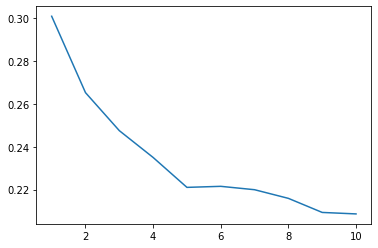

In [118]:
plt.plot(epoch,train_loss)

In [119]:
model=models.load_model("model2_R.h5")

In [120]:
temp_rs=model2.predict(testR_X)

In [122]:
temp_rs=scaler2.inverse_transform(temp_rs)
temp_rs

array([[24.215044],
       [24.353567],
       [24.986425],
       [25.411402],
       [25.329735],
       [22.920399],
       [22.50301 ],
       [23.461834],
       [25.642769],
       [26.905474],
       [28.353851],
       [28.900972],
       [28.382988],
       [27.127268],
       [28.034718],
       [28.579601],
       [28.95927 ],
       [29.402124],
       [30.047926],
       [30.128057],
       [30.069069],
       [29.47108 ],
       [29.487213],
       [29.52674 ],
       [30.018366],
       [30.332428],
       [30.560915],
       [30.438139],
       [30.719313],
       [30.47731 ],
       [30.105473],
       [29.019209],
       [28.297016],
       [27.56638 ],
       [27.52591 ],
       [27.06295 ]], dtype=float32)

In [123]:
testR_Y_inv=scaler2.inverse_transform(testR_Y)

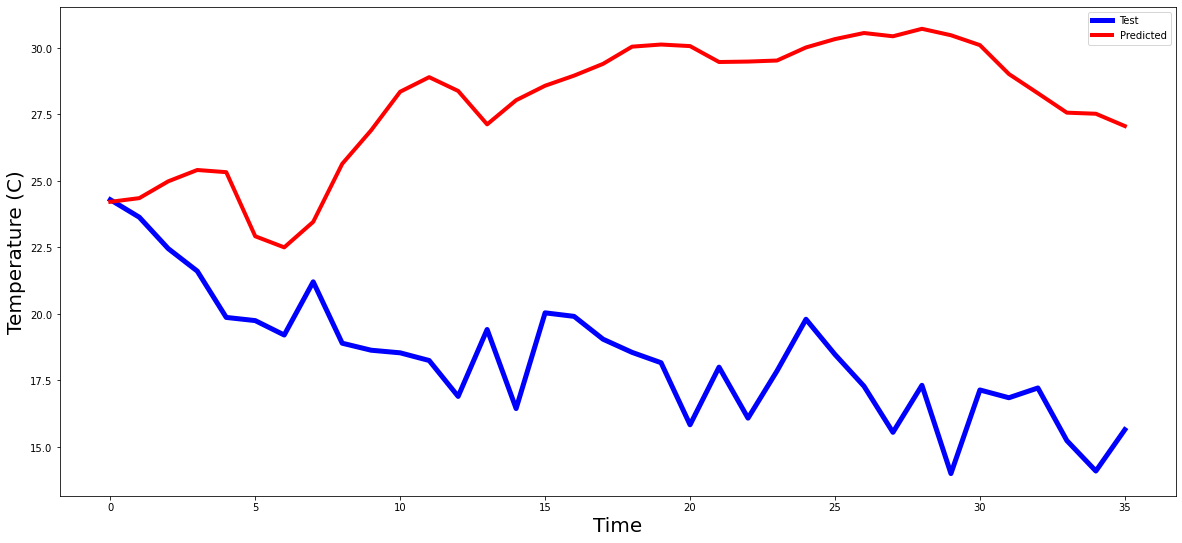

In [124]:
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'blue', linewidth=5)
plt.plot(temp_rs,'r' , linewidth=4)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Temperature (C)", fontsize=20)
plt.legend(('Test','Predicted'))
plt.show()

In [125]:
mse=mean_squared_error(testR_Y_inv, temp_rs)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

Mean Squared Error: 108.58657779691075 and Mean Absolute Error: 9.534536878922616
